### **Deep learning model - LSTM**

### Importing the libraries

In [1]:
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

2024-11-04 05:12:13.210814: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-04 05:12:13.213196: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-04 05:12:13.261858: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-04 05:12:13.262929: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-04 05:12:14.122751: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

### Setting up a Spark session

In [2]:
# Configuring a Spark session
configure_spark = SparkConf().set("spark.driver.host", "127.0.0.1")
spark_configure = SparkContext(conf=configure_spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/11/04 05:12:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Creating a Spark session
spark=SparkSession.builder.getOrCreate()

In [4]:
# Checking if the Spark session is active
spark

### Preparing the data for analysis

In [5]:
# Loading the CSV file into a PySpark data frame
df = spark.read.csv('/home/lab_services_student/RPDA8412/RPDA8412_Analysis Features.csv',header=True,inferSchema=True)

In [6]:
# Converting the PySpark data frame to a Pandas data frame
df_pandas = df.toPandas()

In [7]:
# Viewing the first 5 rows of the data frame
df_pandas.head()

,timeStamp,air_temp,relhum,press,windsp,winddir,max_windsp,precipitation,ghi,dni,dhi
0,2015-01-01 00:00:00,12.4,25.54,1006,2.72,318.6,3.6,0,122.7,632.2,34.78
1,2015-01-01 00:01:00,12.4,25.66,1006,2.38,312.0,3.2,0,119.9,626.2,34.43
2,2015-01-01 00:02:00,12.4,25.60,1006,3.20,309.2,4.1,0,133.2,642.5,47.16
3,2015-01-01 00:03:00,12.4,25.48,1006,2.30,308.8,3.1,0,154.9,621.9,73.33
4,2015-01-01 00:04:00,12.4,25.64,1006,2.50,315.2,3.0,0,153.7,582.9,78.71


In [8]:
# Viewing the shape of the data frame
df_pandas.shape

(17280, 11)

In [9]:
# Viewing information related to the features in the data frame
df_pandas.describe()

,air_temp,relhum,press,windsp,winddir,max_windsp,precipitation,ghi,dni,dhi
count,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.0,17280.000000,17280.000000,17280.000000
mean,8.701582,67.729829,1009.649190,1.270847,188.947271,1.984583,0.0,103.138182,178.210890,37.898906
std,4.993406,15.472275,4.325073,0.617391,99.669510,0.813625,0.0,162.767789,307.588747,64.325903
min,-2.100000,25.480000,1002.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,5.300000,55.160000,1006.000000,0.780000,89.400000,1.400000,0.0,0.000000,0.000000,0.000000
50%,8.600000,72.700000,1010.000000,1.240000,195.000000,2.000000,0.0,0.000000,0.000000,0.051000
75%,12.160000,80.200000,1013.000000,1.680000,287.500000,2.500000,0.0,178.325000,270.150000,58.402500
max,20.400000,91.600000,1019.000000,4.600000,360.000000,7.000000,0.0,588.900000,930.000000,345.000000


In [10]:
# ______code_attribution______
# The following method was taken from GeeksforGeeks
# Author: rajput-ji
# Link: https://www.geeksforgeeks.org/how-to-drop-one-or-multiple-columns-in-pandas-dataframe/

# Removing the columns that will not be used in the analysis
df_new = df_pandas.drop(['press','max_windsp','precipitation','dhi'], axis=1)

# _____end_____

In [11]:
# Viewing the first 5 rows of the data frame after the columns have been dropped
df_new.head()

,timeStamp,air_temp,relhum,windsp,winddir,ghi,dni
0,2015-01-01 00:00:00,12.4,25.54,2.72,318.6,122.7,632.2
1,2015-01-01 00:01:00,12.4,25.66,2.38,312.0,119.9,626.2
2,2015-01-01 00:02:00,12.4,25.60,3.20,309.2,133.2,642.5
3,2015-01-01 00:03:00,12.4,25.48,2.30,308.8,154.9,621.9
4,2015-01-01 00:04:00,12.4,25.64,2.50,315.2,153.7,582.9


In [12]:
# ______code_attribution______
# The following method was taken from Atlassian
# Author: AJ Welch
# Link: https://www.atlassian.com/data/notebook/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe

# Checking to see if there are any values that are missing
df_new.isnull().values.any()

# _____end_____

False

In [13]:
# ______code_attribution______
# The following method was taken from W3Schools
# Author: W3Schools
# Link: https://www.w3schools.com/python/pandas/ref_df_duplicated.asp

# Checking to see if there any duplicate values
df_new.duplicated()

# _____end_____

0        False
1        False
2        False
3        False
4        False
         ...  
17275    False
17276    False
17277    False
17278    False
17279    False
Length: 17280, dtype: bool

### Visualizing the data

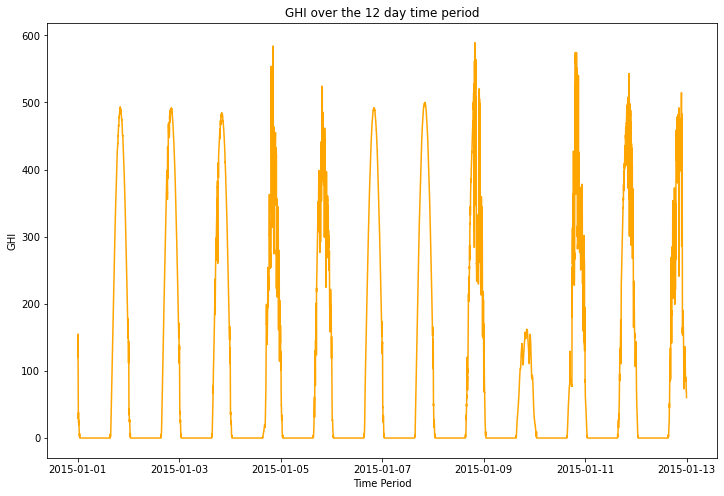

In [14]:
# ______code_attribution______
# The following method was taken from freeCodeCamp
# Author: Ihechikara Abba
# Link: https://www.freecodecamp.org/news/matplotlib-figure-size-change-plot-size-in-python/

# Setting the figure size for the line plot
plt.figure(figsize=(12,8))

# _____end_____

# ______code_attribution______
# The following method was taken from DataCamp
# Author: Arunn Thevapalan
# Link: https://www.datacamp.com/tutorial/line-plots-in-matplotlib-with-python

# Declaring variables for the time period and ghi
time_period = df_new['timeStamp']
ghi = df_new['ghi']

# Converting the time period variable to date time
ghi_time_period = pd.to_datetime(time_period)

# Creating a line plot to display the ghi and specifying the x-axis and y-axis label as well as the title 
plt.plot(ghi_time_period, ghi , color = 'orange')
plt.xlabel('Time Period')
plt.ylabel('GHI')
plt.title('GHI over the 12 day time period')

# Displaying the line plot
plt.show()

# _____end_____

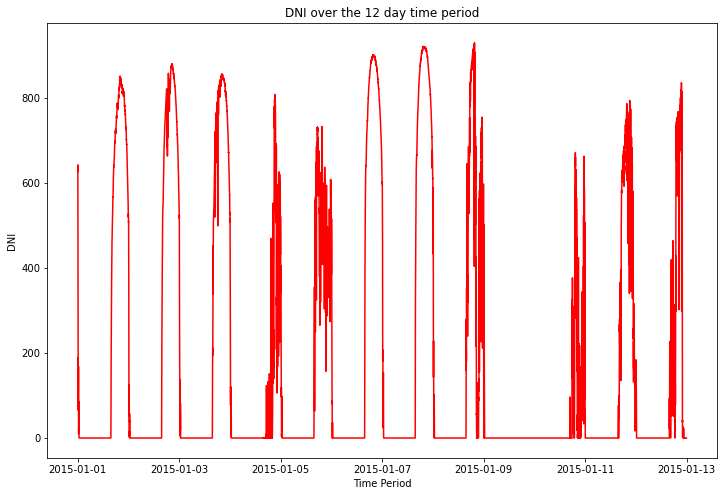

In [15]:
# ______code_attribution______
# The following method was taken from freeCodeCamp
# Author: Ihechikara Abba
# Link: https://www.freecodecamp.org/news/matplotlib-figure-size-change-plot-size-in-python/

# Setting the figure size for the line plot
plt.figure(figsize=(12,8))

# _____end_____

# ______code_attribution______
# The following method was taken from DataCamp
# Author: Arunn Thevapalan
# Link: https://www.datacamp.com/tutorial/line-plots-in-matplotlib-with-python

# Declaring variables for the time period and dni
time_period = df_new['timeStamp']
dni = df_new['dni']

# Converting the time period variable to date time
dni_time_period = pd.to_datetime(time_period)

# Creating a line plot to display the dni and specifying the x-axis and y-axis label as well as the title 
plt.plot(dni_time_period, dni , color = 'red')
plt.xlabel('Time Period')
plt.ylabel('DNI')
plt.title('DNI over the 12 day time period')

# Displaying the line plot
plt.show()

# _____end_____

In [16]:
# ______code_attribution______
# The following method was taken from GeeksforGeeks
# Author: rajput-ji
# Link: https://www.geeksforgeeks.org/how-to-drop-one-or-multiple-columns-in-pandas-dataframe/

# Removing the timeStamp column
df_new = df_new.drop(['timeStamp'], axis=1)

# _____end_____

### Creating the LSTM model

In [17]:
# Assigning X and y variables
df_X = df_new[['air_temp','relhum','windsp','winddir']]
df_y = df_new[['ghi','dni']]

In [18]:
# ______code_attribution______
# The following method was taken from Medium
# Author: Sebastien Simon
# Link: https://medium.com/@sebastienwebdev/forecasting-weather-patterns-with-lstm-a-python-guide-without-dates-433f0356136c

# Scaling the X and y data
scaling = MinMaxScaler(feature_range=(0, 1))
scaled_df_X = scaling.fit_transform(df_X)
scaled_df_y = scaling.fit_transform(df_y)

# _____end_____

In [19]:
# ______code_attribution______
# The following method was taken from Medium
# Author: Vineet Pandya
# Link: https://medium.com/@vineet.pandya/use-tensorflow-lstm-for-time-series-forecasting-770ec789d2ce

# Method that will create sequences for the LSTM model using the X features , y features and the sequence length
def lstm_sequence(X_features,y_features, sequence):

    X = []
    y = []
    
    for i in range(len(X_features) - sequence):
        row = [x for x in X_features[i:i + sequence]]
        X.append(row)
        label = y_features[i + sequence]
        y.append(label)
        
    return np.array(X), np.array(y)

# _____end_____

In [20]:
# ______code_attribution______
# The following method was taken from Medium
# Author: Vineet Pandya
# Link: https://medium.com/@vineet.pandya/use-tensorflow-lstm-for-time-series-forecasting-770ec789d2ce

# Setting a sequence length
sequence_length = 20

# _____end_____

In [21]:
# ______code_attribution______
# The following method was taken from Medium
# Author: Vineet Pandya
# Link: https://medium.com/@vineet.pandya/use-tensorflow-lstm-for-time-series-forecasting-770ec789d2ce

# Creating sequences using the method defined above
X, y = lstm_sequence(scaled_df_X,scaled_df_y, sequence_length)

# _____end_____

In [22]:
# ______code_attribution______
# The following method was taken from Analytics Vidhya
# Author: Sakshi Raheja
# Link: https://www.analyticsvidhya.com/blog/2023/11/train-test-validation-split/

# Creating a train test split and validation split
from sklearn.model_selection import train_test_split
X_train, X_data, y_train, y_data = train_test_split(X, y, test_size=0.2, random_state=0)
X_validation, X_test, y_validation, y_test = train_test_split(X_data, y_data, test_size=0.5, random_state=0)

# _____end_____

In [23]:
# ______code_attribution______
# The following method was taken from Medium
# Author: Vineet Pandya
# Link: https://medium.com/@vineet.pandya/use-tensorflow-lstm-for-time-series-forecasting-770ec789d2ce

# Creating a variable to hold the number of X features that will be used
no_of_features = X.shape[2]

# Creating the LSTM model 
lstm_model= Sequential()
lstm_model.add(InputLayer((sequence_length,no_of_features)))   
lstm_model.add(LSTM(150, return_sequences = True))  
lstm_model.add(LSTM(150))
lstm_model.add(Dense(2, activation = 'relu'))

# _____end_____

In [24]:
# ______code_attribution______
# The following method was taken from Medium
# Author: Vineet Pandya
# Link: https://medium.com/@vineet.pandya/use-tensorflow-lstm-for-time-series-forecasting-770ec789d2ce

# Creating a variable for early stopping to add to the model
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 2)

# _____end_____

In [25]:
# ______code_attribution______
# The following method was taken from Medium
# Author: Vineet Pandya
# Link: https://medium.com/@vineet.pandya/use-tensorflow-lstm-for-time-series-forecasting-770ec789d2ce

# Compiling the LSTM model with the necessary parameters
lstm_model.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate = 0.001) , metrics = RootMeanSquaredError())

# _____end_____

In [26]:
# The following method to train the LSTM model was taken from two tutorials

# ______code_attribution______
# The following method was taken from Medium
# Author: Vineet Pandya
# Link: https://medium.com/@vineet.pandya/use-tensorflow-lstm-for-time-series-forecasting-770ec789d2ce

# ______code_attribution______
# The following method was taken from Medium
# Author: Sebastien Simon
# Link: https://medium.com/@sebastienwebdev/forecasting-weather-patterns-with-lstm-a-python-guide-without-dates-433f0356136c

# Fitting the data and specifying the parameters for the LSTM model
lstm_model.fit(X_train, y_train, validation_data = (X_validation, y_validation),epochs = 100, callbacks = [early_stopping], batch_size= 64)

# _____end_____

Epoch 1/100
216/216 [==============================] - 11s 39ms/step - loss: 0.0601 - root_mean_squared_error: 0.2451 - val_loss: 0.0479 - val_root_mean_squared_error: 0.2188
Epoch 2/100
216/216 [==============================] - 8s 36ms/step - loss: 0.0422 - root_mean_squared_error: 0.2055 - val_loss: 0.0362 - val_root_mean_squared_error: 0.1903
Epoch 3/100
216/216 [==============================] - 8s 37ms/step - loss: 0.0331 - root_mean_squared_error: 0.1819 - val_loss: 0.0289 - val_root_mean_squared_error: 0.1700
Epoch 4/100
216/216 [==============================] - 8s 35ms/step - loss: 0.0288 - root_mean_squared_error: 0.1697 - val_loss: 0.0289 - val_root_mean_squared_error: 0.1699
Epoch 5/100
216/216 [==============================] - 8s 35ms/step - loss: 0.0289 - root_mean_squared_error: 0.1700 - val_loss: 0.0278 - val_root_mean_squared_error: 0.1667
Epoch 6/100
216/216 [==============================] - 8s 37ms/step - loss: 0.0279 - root_mean_squared_error: 0.1670 - val_loss: 

### Loss and error graph

<AxesSubplot:>

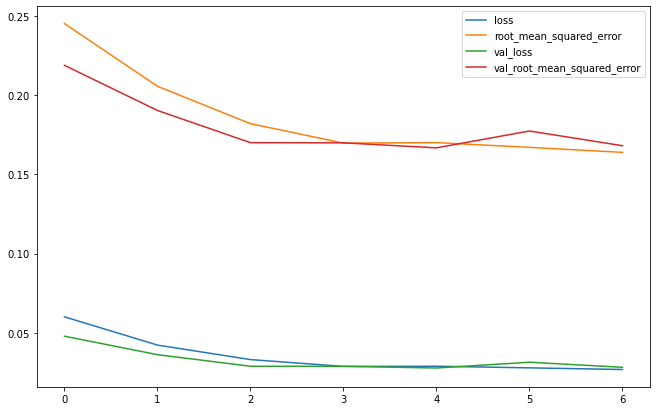

In [27]:
# ______code_attribution______
# The following method was taken from Medium
# Author: Vineet Pandya
# Link: https://medium.com/@vineet.pandya/use-tensorflow-lstm-for-time-series-forecasting-770ec789d2ce

loss_error_graph = pd.DataFrame(lstm_model.history.history)

loss_error_graph.plot(figsize = (11,7))

# _____end_____

### Making predictions

In [ ]:
# ______code_attribution______
# The following method was taken from Medium
# Author: Sebastien Simon
# Link: https://medium.com/@sebastienwebdev/forecasting-weather-patterns-with-lstm-a-python-guide-without-dates-433f0356136c

# Making a prediction using the test data
solar_irradiance_pred = lstm_model.predict(X_test)

# Inverse transforming the scaled predictions
solar_irradiance_pred_final = scaling.inverse_transform(solar_irradiance_pred)

# _____end_____

# Viewing the predictions
solar_irradiance_pred_final

54/54 [==============================] - 1s 8ms/step


array([[  0.     ,   0.     ],
       [  0.     ,   0.     ],
       [ 68.25698,  59.97684],
       ...,
       [286.05234, 541.8001 ],
       [  0.     ,   0.     ],
       [  0.     ,   0.     ]], dtype=float32)

In [29]:
# ______code_attribution______
# The following method was taken from Medium
# Author: Sebastien Simon
# Link: https://medium.com/@sebastienwebdev/forecasting-weather-patterns-with-lstm-a-python-guide-without-dates-433f0356136c

# Inverse transforming the scaled y test data
y_final=scaling.inverse_transform(y_test)

# _____end_____


### Evaluating the model

#### Mean square error

In [30]:
mse = mean_squared_error(y_final,solar_irradiance_pred_final)
mse

18318.464754148263

#### Root mean square error

In [31]:
rmse = root_mean_squared_error(y_final,solar_irradiance_pred_final)
rmse

127.97106993219222

#### Mean absolute percentage error

In [32]:
mape = mean_absolute_percentage_error(y_final,solar_irradiance_pred_final)
mape

5.06861035840335e+16

#### R2 score

In [33]:
r2=r2_score(y_final,solar_irradiance_pred_final)
r2

0.7227911529297544

#### Mean absolute error

In [34]:
mae = mean_absolute_error(y_final,solar_irradiance_pred_final)
mae

66.91334193144588